In [3]:
!pip install torchvggish
!pip install resampy  # required for VGGish preprocessing
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvggish import vggish, vggish_input
import torch.nn.functional as F
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split

In [4]:
#Load Data
df = pd.read_csv('/content/drive/MyDrive/multimodal_dataset_normalized.csv')
display(df.head())

,Audio_Song,Lyric_Song,Arousal,Valence,Quadrant,Emotion,lyric_id,word_count,unique_word_count,lexical_diversity,...,rms_mean,rms_std,beat_strength,low_energy_ratio,energy_entropy,brightness,warmth,activity,harmonic_energy_ratio,harmonicity
0,A005,L055,0.78750,0.68750,Q1,Excited,L055,0.583846,-0.032136,-1.136493,...,-1.315662,-1.165455,0.896397,-0.700513,-0.145042,1.086334,-0.092941,[0.06471955],-1.951364,-0.583475
1,A011,L061,0.68125,0.85625,Q1,Happy,L061,-0.549140,-0.974930,-1.286263,...,0.107522,-0.408386,0.006682,0.068631,0.750471,0.147696,0.040220,[0.18521025],0.472448,-0.078961
2,A014,L064,0.86250,0.72500,Q1,Excited,L064,0.415581,-0.162177,-1.133997,...,0.361195,-0.265328,0.710477,-0.673247,0.854382,1.970159,-0.798261,[0.17745368],-0.949336,-0.454885
3,A019,L069,0.78125,0.81875,Q1,Happy,L069,-0.229436,-0.308472,-0.401603,...,-0.219121,-0.979168,-0.061622,-0.340510,1.062094,0.474343,0.110013,[0.13742129],0.244760,-0.150335
4,A022,L072,0.76875,0.83750,Q1,Happy,L072,-0.599619,-0.828634,-0.755787,...,0.916902,0.959027,-0.008507,-0.482841,0.298920,-0.169472,0.269772,[0.22606403],-0.078616,-0.234134


In [5]:
#Emotion Class
unique_items = df["Emotion"].unique()
print(unique_items)

['Excited' 'Happy' 'Nervous' 'Intense' 'Melancholic' 'Sad' 'Calm'
 'Relaxed']


In [6]:
#Extract path and emotion
data_dir = "/content/drive/MyDrive/audio"
labels_dict = {f"{row['Quadrant']}/{row['Audio_Song']}.mp3": row['Emotion']
               for _, row in df.iterrows()}
print(labels_dict)

{'Q1/A005.mp3': 'Excited', 'Q1/A011.mp3': 'Happy', 'Q1/A014.mp3': 'Excited', 'Q1/A019.mp3': 'Happy', 'Q1/A022.mp3': 'Happy', 'Q1/A024.mp3': 'Happy', 'Q1/A039.mp3': 'Happy', 'Q1/A042.mp3': 'Happy', 'Q1/A043.mp3': 'Happy', 'Q1/A047.mp3': 'Happy', 'Q1/A050.mp3': 'Excited', 'Q1/A064-116.mp3': 'Happy', 'Q1/A077-122.mp3': 'Excited', 'Q1/A086-123.mp3': 'Happy', 'Q1/A092-96.mp3': 'Happy', 'Q1/A094-110.mp3': 'Happy', 'Q1/A095-113.mp3': 'Happy', 'Q1/A100-124.mp3': 'Happy', 'Q1/A101-111.mp3': 'Happy', 'Q1/A102-114.mp3': 'Excited', 'Q1/A104-119.mp3': 'Excited', 'Q1/A105-117.mp3': 'Excited', 'Q1/A107-115.mp3': 'Excited', 'Q1/A114-120.mp3': 'Happy', 'Q1/A115-84.mp3': 'Happy', 'Q1/A128-109.mp3': 'Excited', 'Q1/A132-121.mp3': 'Happy', 'Q1/A146-118.mp3': 'Excited', 'Q1/A148-102.mp3': 'Happy', 'Q1/A152-108.mp3': 'Happy', 'Q1/A153-130.mp3': 'Happy', 'Q1/A160-149.mp3': 'Happy', 'Q1/A162.mp3': 'Happy', 'Q1/A166.mp3': 'Excited', 'Q1/A167.mp3': 'Happy', 'Q1/A187.mp3': 'Happy', 'Q1/A196.mp3': 'Excited', 'Q1/M

In [7]:
#Settings
duration = 30
sr = 16000
num_classes = 8
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Preprocessing
X_list = []
y_list = []


target_frames = 1876
all_classes = ['Excited', 'Happy', 'Nervous', 'Intense',
               'Melancholic', 'Sad', 'Calm', 'Relaxed']
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
print("Class to index mapping:", class_to_idx)


for file, label in labels_dict.items():
    filepath = os.path.join(data_dir, file)
    y, _ = librosa.load(filepath, sr=sr, duration=duration)

    # VGGish preprocessing: convert waveform to log-mel spectrogram
    mel = vggish_input.waveform_to_examples(y, sr)

    # mel shape: (num_patches, 1, 96, 64)
    mel_tensor = torch.tensor(mel, dtype=torch.float32)

    # Average over patches to get single embedding per clip
    mel_tensor = mel_tensor.mean(dim=0, keepdim=True)  # shape: (1, 1, 96, 64)

    X_list.append(mel_tensor)
    y_list.append(class_to_idx[label])

X = torch.cat(X_list, dim=0)  # shape: (N, 1, 96, 64)
y = torch.tensor(y_list, dtype=torch.long)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Class to index mapping: {'Excited': 0, 'Happy': 1, 'Nervous': 2, 'Intense': 3, 'Melancholic': 4, 'Sad': 5, 'Calm': 6, 'Relaxed': 7}


/tmp/ipython-input-2713613647.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_tensor = torch.tensor(mel, dtype=torch.float32)


Train shape: torch.Size([1329, 1, 96, 64]) torch.Size([1329])
Val shape: torch.Size([443, 1, 96, 64]) torch.Size([443])
Test shape: torch.Size([444, 1, 96, 64]) torch.Size([444])


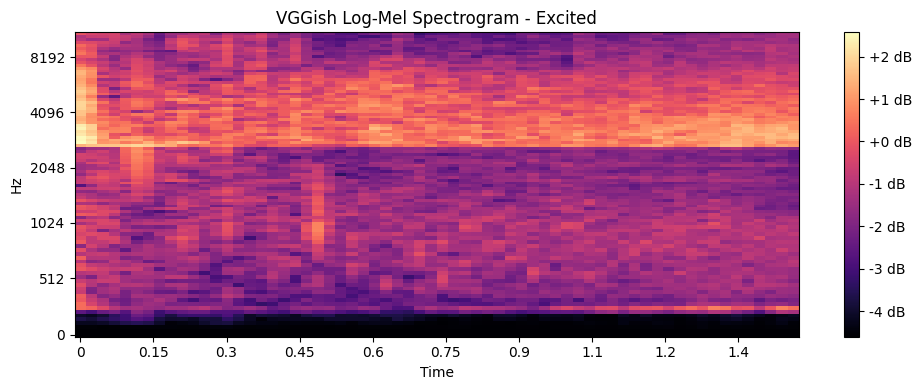

In [8]:
# Take the first audio clip
file, label = list(labels_dict.items())[0]
filepath = os.path.join(data_dir, file)
y, _ = librosa.load(filepath, sr=16000, duration=duration)

# Convert waveform to VGGish log-mel spectrogram
mel_patches = vggish_input.waveform_to_examples(y, sr)  # (num_patches, 1, 96, 64)

# Pick the first patch for visualization
mel_example = mel_patches[0, 0, :, :]  # (96, 64)

# Detach and convert to NumPy
if isinstance(mel_example, torch.Tensor):
    mel_example = mel_example.detach().numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_example, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"VGGish Log-Mel Spectrogram - {label}")
plt.tight_layout()
plt.show()

In [9]:
#load pretrained
vgg_model = vggish()
vgg_model.eval()
vgg_model.to(device)

# Freeze VGGish layers
for param in vgg_model.parameters():
    param.requires_grad = False


# Add FC classifier for emotions
fc_model = nn.Sequential(
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, num_classes)
).to(device)

Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish_pca_params-970ea276.pth" to /root/.cache/torch/hub/checkpoints/vggish_pca_params-970ea276.pth


100%|██████████| 177k/177k [00:00<00:00, 6.17MB/s]


Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth


100%|██████████| 275M/275M [00:02<00:00, 141MB/s]


In [12]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=1e-3)
num_epochs = 5
for epoch in range(num_epochs):
    #Training
    fc_model.train()        # train FC only

    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            vgg_model.eval()
            embeddings = vgg_model(X_batch)  # shape: (batch, 128)

        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)  # Add batch dimension at position 0
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)  # Flatten to [batch_size, 128]


        logits = fc_model(embeddings)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(logits, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    #Validation
    fc_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            embeddings = vgg_model(X_batch)
            logits = fc_model(embeddings)
            loss = criterion(logits, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(logits, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/5 | Train Loss: 1.5726, Train Acc: 0.3965 | Val Loss: 1.4949, Val Acc: 0.4221
Epoch 2/5 | Train Loss: 1.5593, Train Acc: 0.4289 | Val Loss: 1.4786, Val Acc: 0.4176
Epoch 3/5 | Train Loss: 1.5920, Train Acc: 0.3905 | Val Loss: 1.4455, Val Acc: 0.4266
Epoch 4/5 | Train Loss: 1.5597, Train Acc: 0.3965 | Val Loss: 1.4455, Val Acc: 0.4312
Epoch 5/5 | Train Loss: 1.5277, Train Acc: 0.3988 | Val Loss: 1.4117, Val Acc: 0.4424


In [13]:
#Testing
fc_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        embeddings = vgg_model(X_batch)
        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)
        logits = fc_model(embeddings)
        _, predicted = torch.max(logits, 1)

        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.4505
